In [1]:
%pylab inline 

%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'..')

from tensorflow_probability.python.internal.backend import jax as tf
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax

Populating the interactive namespace from numpy and matplotlib


In [2]:
from jax_nf.real_nvp import RealNVP

In [3]:
from flax import nn
import jax
import jax.numpy as np
import numpy as onp
import flax 

tfb = tfp.bijectors
tfd = tfp.distributions

In [4]:
@nn.module
def NeuralSplineCoupling(x, nunits, nbins=32):

  def bin_positions(x):
    x = np.reshape(x, [-1, nunits, nbins])
    return nn.activation.softmax(x, axis=-1) *  (2. - nbins * 1e-2) + 1e-2
  
  def slopes(x):
    x = np.reshape(x, [-1, nunits, nbins - 1])
    return nn.activation.softplus(x) + 1e-2

  # Let's have one more non stupid layer
  net = nn.leaky_relu(nn.Dense(x, 128))
  net = nn.leaky_relu(nn.Dense(net, 128))

  bin_widths = bin_positions(nn.Dense(net, nunits*nbins))
  bin_heights = bin_positions(nn.Dense(net, nunits*nbins))
  knot_slopes = slopes(nn.Dense(net, nunits*(nbins-1)))

  return tfb.RationalQuadraticSpline(
            bin_widths=bin_widths,
            bin_heights=bin_heights,
            knot_slopes=knot_slopes)

In [5]:
# Instantiate the splines
d = 2
dummy_input = np.zeros((1, d//2))
_, params1 = NeuralSplineCoupling.init(jax.random.PRNGKey(0), dummy_input, d//2)

/home/francois/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [6]:
from functools import partial
spline1 = partial(NeuralSplineCoupling.call, params1)

In [7]:
nvp = tfd.TransformedDistribution(
        tfd.Normal(0,1),
        bijector=RealNVP(1, bijector_fn=spline1),
        event_shape=(2,))

In [8]:
samps = nvp.sample((1000,), seed=jax.random.PRNGKey(1))

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


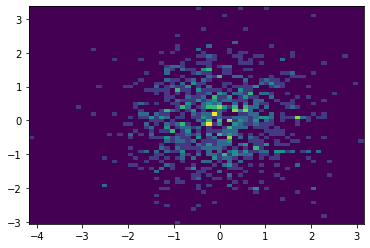

In [9]:
hist2d(samps[:,0], samps[:,1],64);

In [10]:
# Sweet :-D Hurray for TFP

In [11]:
# Let's try to learn a density

In [12]:
d=2
@nn.module
def NeuralSplineFlow(x):
    
    spline1 = NeuralSplineCoupling.shared(name='spline1')
    spline2 = NeuralSplineCoupling.shared(name='spline2')
    
    # Computes the likelihood of these x
    chain = tfb.Chain([
        tfb.Scale(10),
        RealNVP(d//2, bijector_fn=spline1),
        tfb.Permute([1,0]),
        RealNVP(d//2, bijector_fn=spline2),
        tfb.Permute([1,0]),
        tfb.Scale(0.1)
    ])
    
    nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=chain,
                event_shape=(d,))
    
    return nvp.log_prob(x)

In [13]:
dummy_input = np.zeros((1,d))
res, params = NeuralSplineFlow.init(jax.random.PRNGKey(0), dummy_input)

In [14]:
model = nn.Model(NeuralSplineFlow, params)

In [15]:
# Ok, sweet
@jax.jit
def train_step(optimizer, batch):
    
    def loss_fn(model):
        log_prob = model(batch['x'])
        return -np.mean(log_prob)
    
    loss, grad = jax.value_and_grad(loss_fn)(optimizer.target)
    optimizer = optimizer.apply_gradient(grad)
    return loss, optimizer

In [16]:
# Now let's draw ou famous two moons
from sklearn import datasets

# Experimenting with only a fixed number of points
batch_size=512
def get_batch():
    x, y = datasets.make_moons(n_samples=batch_size, noise=.05)
    return {'x': x}

In [17]:
# okokokok, let's try it out
optimizer = flax.optim.Adam(learning_rate=0.001).create(model)
losses = []

In [33]:
for i in range(2000):
    batch = get_batch()
    l, optimizer = train_step(optimizer, batch)
    losses.append(l)
    if  i %100 ==0:
        print(l)

0.33965787
0.39848748
0.39466545
0.37984976
0.33249596
0.33748803
0.32456493
0.34433728
0.43304682
0.41843653
0.36077815
0.3994238
0.39412624
0.35455206
0.3839511
0.35352263
0.35259557
0.27102777
0.3767648
0.3559861


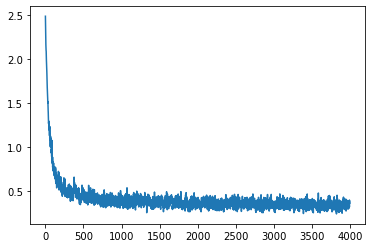

In [34]:
plot(losses)

In [35]:
# ok, fine, let's see if we can rebuild our flow
@nn.module
def NeuralSplineFlowSampler(key, n_samples):
    
    spline1 = NeuralSplineCoupling.shared(name='spline1')
    spline2 = NeuralSplineCoupling.shared(name='spline2')
    
    # Computes the likelihood of these x
    chain = tfb.Chain([
        tfb.Scale(10),
        RealNVP(d//2, bijector_fn=spline1),
        tfb.Permute([1,0]),
        RealNVP(d//2, bijector_fn=spline2),
        tfb.Permute([1,0]),
        tfb.Scale(0.1)
    ])
    nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=chain,
                event_shape=(d,))
    
    return nvp.sample(n_samples, seed=key)

In [36]:
sampler = nn.Model(NeuralSplineFlowSampler, optimizer.target.params)

In [37]:
samps = sampler(jax.random.PRNGKey(1),10000)

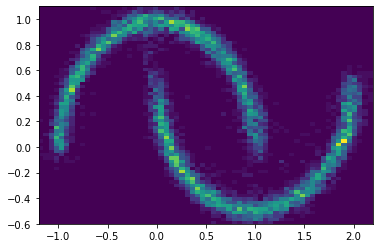

In [38]:
hist2d(samps[:,0], samps[:,1],64, range=[[-1.2,2.2],[-0.6,1.1]]);

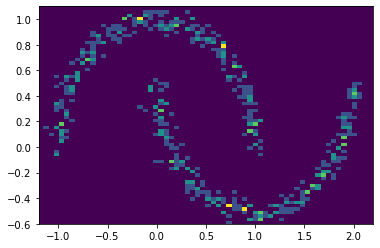

In [39]:
hist2d(batch['x'][:,0], batch['x'][:,1],64, range=[[-1.2,2.2],[-0.6,1.1]]);